<a href="https://colab.research.google.com/github/GUGOFO/Reconhecimento-de-Jogos/blob/main/Untitled5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import keras
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando o dispositivo: {device}")

Usando o dispositivo: cuda


In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive', force_remount=True)

zip_path_in_drive = '/content/drive/MyDrive/database_jogos.zip'
local_path = '/content/'
extract_dir = os.path.join(local_path, 'database_jogos')

print(f"Copiando o ficheiro '{zip_path_in_drive}' para o ambiente local...")
!cp "{zip_path_in_drive}" "{local_path}"
print("Cópia concluída!")

print("\nPreparando o diretório de extração...")
if os.path.isdir(extract_dir):
    !rm -rf "{extract_dir}"
elif os.path.isfile(extract_dir):
    !rm "{extract_dir}"

os.makedirs(extract_dir, exist_ok=True)
print(f"Diretório '{extract_dir}' preparado.")

print("\nExtraindo as imagens do ficheiro .zip...")
!unzip -o -q "{local_path}database_jogos.zip" -d "{extract_dir}"
print("Extração concluída!")

print("\nConteúdo do diretório de extração:")
!ls -F "{extract_dir}"

Mounted at /content/drive
Copiando o ficheiro '/content/drive/MyDrive/database_jogos.zip' para o ambiente local...
Cópia concluída!

Preparando o diretório de extração...
Diretório '/content/database_jogos' preparado.

Extraindo as imagens do ficheiro .zip...
Extração concluída!

Conteúdo do diretório de extração:
Alan_Wake/	       Dishonored_Series/  Mafia_Series/
Batman_Arkham_Series/  Doom/		   Metro_Last_Light/
Bioshock_Infinite/     Fallout_New_Vegas/  The_Elder_Scrolls_V_Skyrim/
Borderlands_Series/    God_Of_War/	   Uncharted/
CS/		       GTA_V/


In [ ]:
import tensorflow as tf
import os
import numpy as np
from sklearn.model_selection import train_test_split

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
DATA_DIR = '/content/database_jogos/'
SPLIT_RATIO = 0.2
SEED = 1337

print("Mapeando todos os ficheiros de imagem...")
filepaths = []
labels = []
class_names = sorted(os.listdir(DATA_DIR))
class_map = {name: i for i, name in enumerate(class_names)}
for class_name in class_names:
    class_path = os.path.join(DATA_DIR, class_name)
    for filename in os.listdir(class_path):
        filepaths.append(os.path.join(class_path, filename))
        labels.append(class_map[class_name])
filepaths = np.array(filepaths)
labels = np.array(labels)

print("Fazendo a divisão estratificada dos dados (80-20)...")
train_paths, val_paths, train_labels, val_labels = train_test_split(
    filepaths, labels, test_size=SPLIT_RATIO, stratify=labels, random_state=SEED
)
print(f"\nTotal de imagens de treino: {len(train_paths)}")
print(f"Total de imagens de validação: {len(val_paths)}")

def process_path(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    return img, label

train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))

train_ds = train_ds.map(process_path).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(process_path).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(f"\nEncontradas {len(class_names)} classes:")
print(class_names)
print("\nDatasets criados com novo IMAGE_SIZE e prontos para prosseguir!")

Mapeando todos os ficheiros de imagem...
Fazendo a divisão estratificada dos dados (80-20)...

Total de imagens de treino: 2636
Total de imagens de validação: 660

Encontradas 14 classes:
['Alan_Wake', 'Batman_Arkham_Series', 'Bioshock_Infinite', 'Borderlands_Series', 'CS', 'Dishonored_Series', 'Doom', 'Fallout_New_Vegas', 'GTA_V', 'God_Of_War', 'Mafia_Series', 'Metro_Last_Light', 'The_Elder_Scrolls_V_Skyrim', 'Uncharted']

Datasets criados com novo IMAGE_SIZE e prontos para prosseguir!


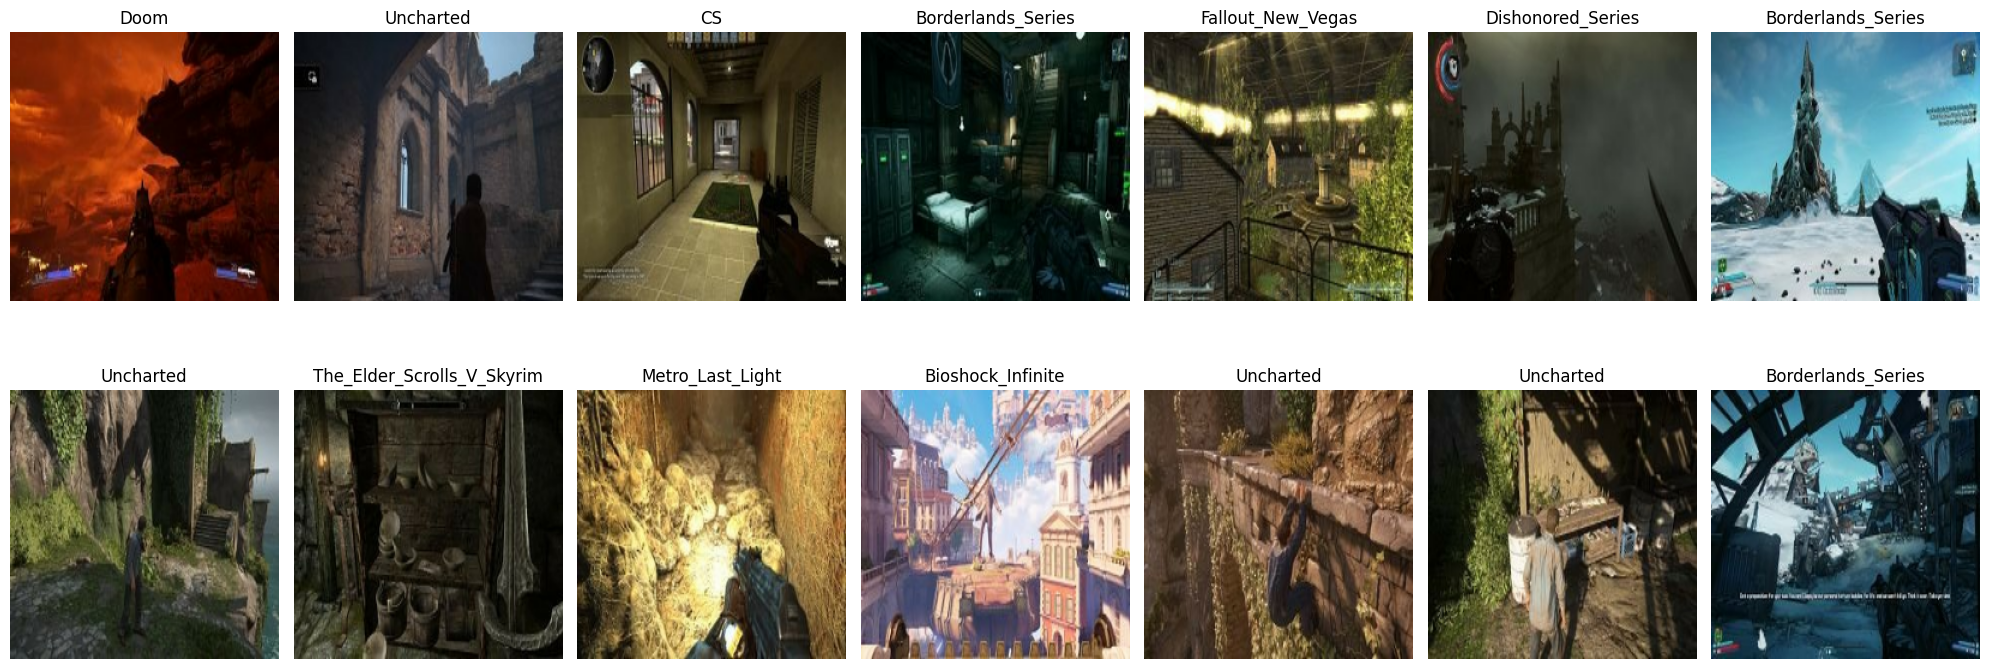

In [ ]:
plt.figure(figsize=(20, 8))

for images, labels in train_ds.take(1):
    for i in range(14):
        ax = plt.subplot(2, 7, i + 1)

        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
from keras import layers

num_classes = len(class_names)
input_shape = (224, 224, 3)
data_augmentation = keras.Sequential(
    [
      layers.RandomFlip("horizontal_and_vertical"),
      layers.RandomRotation(0.2),
      layers.RandomZoom(0.3),
      layers.Lambda(lambda x: tf.image.random_brightness(x, max_delta=0.3)),
      layers.Lambda(lambda x: tf.image.random_contrast(x, lower=0.7, upper=1.3)),
      layers.RandomTranslation(0.1, 0.1),
    ],
    name="data_augmentation",
)

base_model = keras.applications.DenseNet169(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)

base_model.trainable = False

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        data_augmentation,
        layers.Lambda(keras.applications.densenet.preprocess_input),
        base_model,
        layers.GlobalAveragePooling2D(),

        layers.Dense(512, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),

        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ],
    name="IA_KERAS_Transfer_Learning_DenseNet",
)

model.summary()

51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "IA_KERAS_Transfer_Learning_DenseNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet169 (Functional)        │ (None, 7, 7, 1664)     │    12,642,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1664)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       852,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14)             │         7,182 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,502,542 (51.51 MB)

 Trainable params: 859,662 (3.28 MB)

 Non-trainable params: 12,642,880 (48.23 MB)

In [ ]:
from keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

print("Modelo CNN compilado com sucesso e pronto para ser treinado!")

epochs = 35

print("Iniciando o treinamento otimizado...")

history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=[lr_scheduler]
)

print("\nTreinamento otimizado concluído!")

Modelo CNN compilado com sucesso e pronto para ser treinado!
Iniciando o treinamento otimizado...
Epoch 1/35
83/83 ━━━━━━━━━━━━━━━━━━━━ 62s 346ms/step - accuracy: 0.1897 - loss: 3.1754 - val_accuracy: 0.5939 - val_loss: 1.7750 - learning_rate: 0.0010
Epoch 2/35
83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 225ms/step - accuracy: 0.5062 - loss: 1.8788 - val_accuracy: 0.6121 - val_loss: 1.5574 - learning_rate: 0.0010
Epoch 3/35
83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 226ms/step - accuracy: 0.5524 - loss: 1.6168 - val_accuracy: 0.6955 - val_loss: 1.2639 - learning_rate: 0.0010
Epoch 4/35
83/83 ━━━━━━━━━━━━━━━━━━━━ 20s 238ms/step - accuracy: 0.6101 - loss: 1.4577 - val_accuracy: 0.7106 - val_loss: 1.2130 - learning_rate: 0.0010
Epoch 5/35
83/83 ━━━━━━━━━━━━━━━━━━━━ 20s 238ms/step - accuracy: 0.6395 - loss: 1.3643 - val_accuracy: 0.7364 - val_loss: 1.0883 - learning_rate: 0.0010
Epoch 6/35
83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 233ms/step - accuracy: 0.6482 - loss: 1.2770 - val_accuracy: 0.7742 - val_loss: 1.0324 - learni

In [ ]:
print("\n--- Iniciando a fase de Fine-Tuning Organizado ---")

base_model.trainable = True


fine_tune_at = 314

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

print(f"Congelando as primeiras {fine_tune_at} camadas da DenseNet.")
print(f"Treinando as últimas {len(base_model.layers) - fine_tune_at} camadas (o último bloco).")

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
print("\nModelo recompilado para Fine-Tuning gradual.")

fine_tune_epochs = 20
total_epochs =  epochs + fine_tune_epochs

history_fine_tune = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=val_ds,
)

print("\nFase de Fine-Tuning concluída!")


--- Iniciando a fase de Fine-Tuning Organizado ---
Congelando as primeiras 314 camadas da DenseNet.
Treinando as últimas 281 camadas (o último bloco).

Modelo recompilado para Fine-Tuning gradual.
Epoch 35/55
83/83 ━━━━━━━━━━━━━━━━━━━━ 103s 500ms/step - accuracy: 0.6197 - loss: 1.4491 - val_accuracy: 0.7818 - val_loss: 0.9181
Epoch 36/55
83/83 ━━━━━━━━━━━━━━━━━━━━ 32s 388ms/step - accuracy: 0.7173 - loss: 1.0420 - val_accuracy: 0.7985 - val_loss: 0.8481
Epoch 37/55
83/83 ━━━━━━━━━━━━━━━━━━━━ 32s 391ms/step - accuracy: 0.7571 - loss: 0.9130 - val_accuracy: 0.8152 - val_loss: 0.7995
Epoch 38/55
83/83 ━━━━━━━━━━━━━━━━━━━━ 32s 389ms/step - accuracy: 0.7897 - loss: 0.8529 - val_accuracy: 0.8303 - val_loss: 0.7593
Epoch 39/55
83/83 ━━━━━━━━━━━━━━━━━━━━ 33s 395ms/step - accuracy: 0.8005 - loss: 0.8082 - val_accuracy: 0.8424 - val_loss: 0.7315
Epoch 40/55
83/83 ━━━━━━━━━━━━━━━━━━━━ 32s 390ms/step - accuracy: 0.8152 - loss: 0.7724 - val_accuracy: 0.8439 - val_loss: 0.7187
Epoch 41/55
83/83 ━━━

In [ ]:
print("--- Avaliação Final do Modelo CNN no Conjunto de Teste ---")
loss, accuracy = model.evaluate(val_ds, verbose=1)

print("\n--- Resultados Finais ---")
print(f"Acurácia Final no Conjunto de Teste: {accuracy * 100:.2f}%")
print(f"Perda Final no Conjunto de Teste: {loss:.4f}")

--- Avaliação Final do Modelo CNN no Conjunto de Teste ---
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 188ms/step - accuracy: 0.8824 - loss: 0.5860

--- Resultados Finais ---
Acurácia Final no Conjunto de Teste: 88.94%
Perda Final no Conjunto de Teste: 0.5558


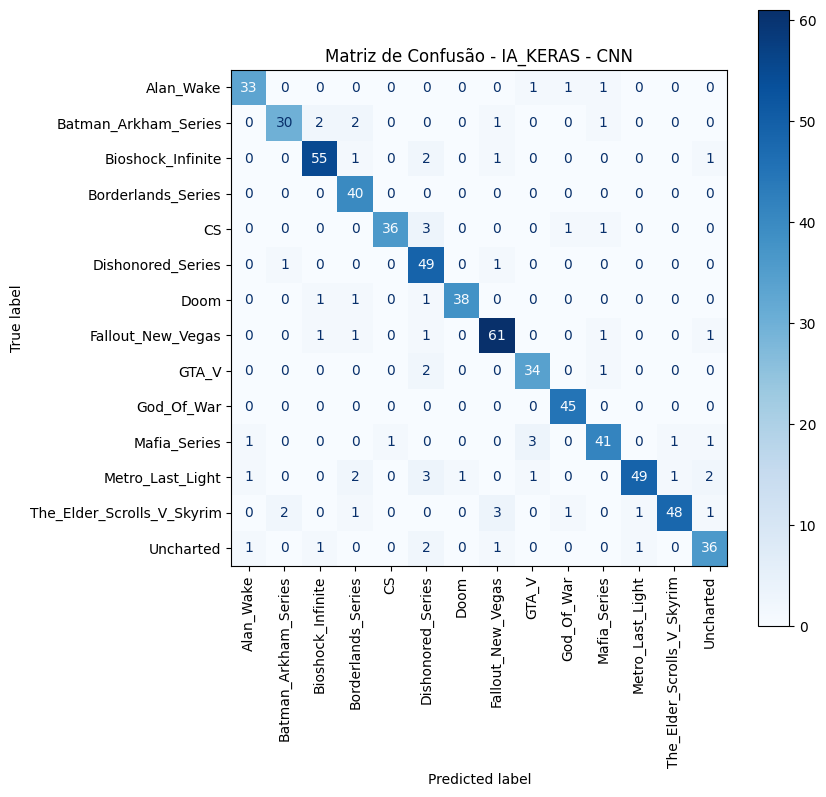

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_preds = []
all_labels = []

for images, labels in val_ds:
    predictions = model.predict(images, verbose=0)
    predicted_labels = np.argmax(predictions, axis=1)

    all_preds.extend(predicted_labels)
    all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Matriz de Confusão - IA_KERAS - CNN")
plt.show()

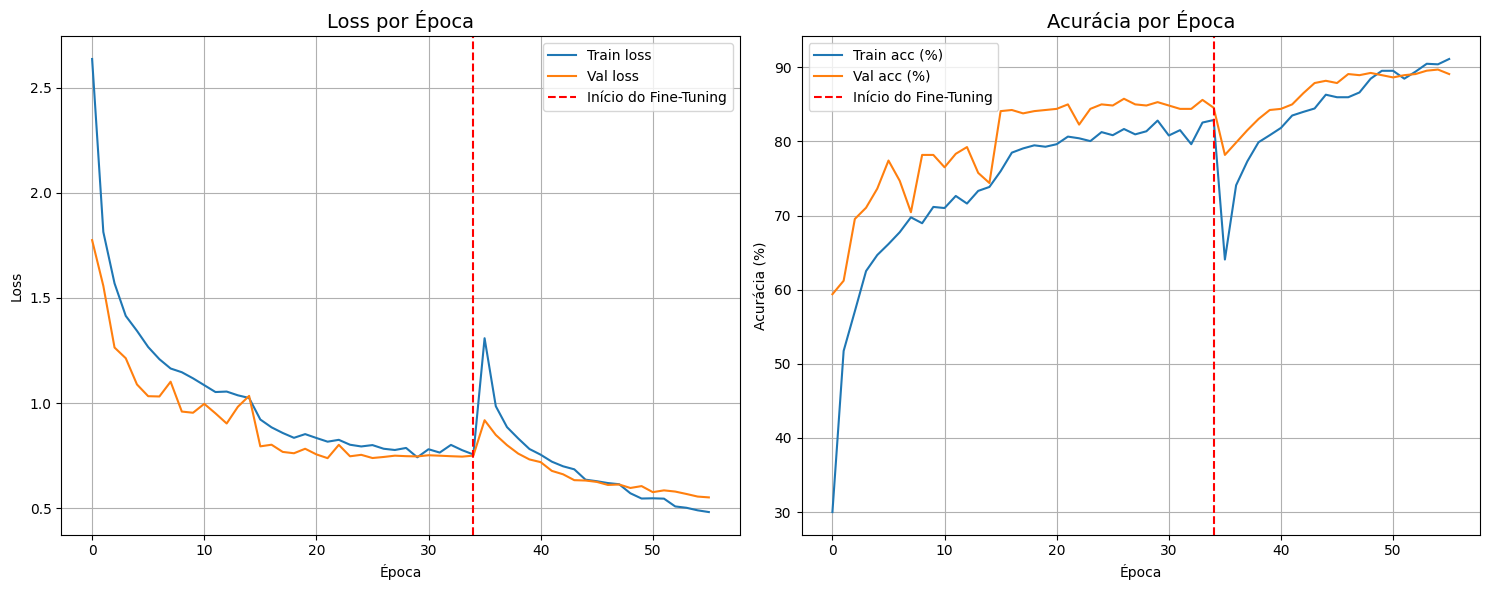

In [ ]:
import matplotlib.pyplot as plt

initial_acc = history.history['accuracy']
initial_val_acc = history.history['val_accuracy']
initial_loss = history.history['loss']
initial_val_loss = history.history['val_loss']

full_acc = initial_acc + history_fine_tune.history['accuracy']
full_val_acc = initial_val_acc + history_fine_tune.history['val_accuracy']
full_loss = initial_loss + history_fine_tune.history['loss']
full_val_loss = initial_val_loss + history_fine_tune.history['val_loss']

full_acc_percent = [acc * 100 for acc in full_acc]
full_val_acc_percent = [acc * 100 for acc in full_val_acc]

def plot_history(train_losses, train_accs, val_losses, val_accs):
    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train loss', color='#1f77b4')
    plt.plot(val_losses,   label='Val loss', color='#ff7f0e')
    plt.axvline(x=len(initial_acc)-1, color='r', linestyle='--', label='Início do Fine-Tuning')
    plt.title('Loss por Época', fontsize=14)
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train acc (%)', color='#1f77b4')
    plt.plot(val_accs,   label='Val acc (%)', color='#ff7f0e')
    plt.axvline(x=len(initial_acc)-1, color='r', linestyle='--', label='Início do Fine-Tuning')
    plt.title('Acurácia por Época', fontsize=14)
    plt.xlabel('Época')
    plt.ylabel('Acurácia (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_history(full_loss, full_acc_percent, full_val_loss, full_val_acc_percent)


--- Amostra Aleatória de Previsões (Imagens diferentes a cada vez) ---


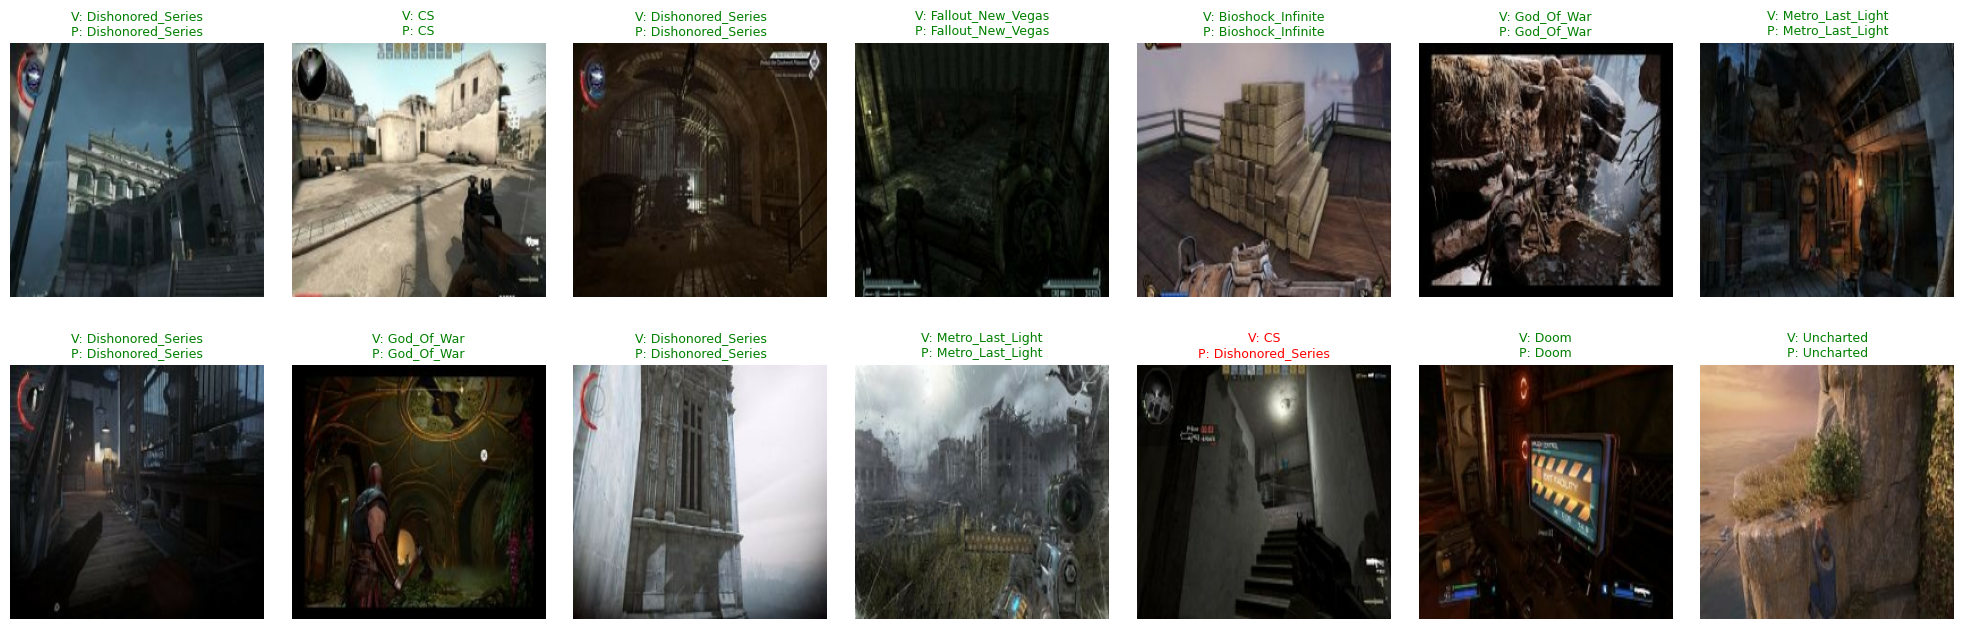

In [ ]:
print("\n--- Amostra Aleatória de Previsões (Imagens diferentes a cada vez) ---")

plt.figure(figsize=(20, 7))

for images, labels in val_ds.shuffle(buffer_size=1000).take(1):
    predictions = model.predict(images, verbose=0)
    predicted_labels = np.argmax(predictions, axis=1)

    for i in range(min(14, len(images))):
        ax = plt.subplot(2, 7, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        true_label_name = class_names[labels[i]]
        predicted_label_name = class_names[predicted_labels[i]]
        color = "green" if true_label_name == predicted_label_name else "red"
        plt.title(f"V: {true_label_name}\nP: {predicted_label_name}", color=color, fontsize=9)
        plt.axis("off")

plt.tight_layout(pad=2.0)
plt.show()


--- Análise Profunda de uma Previsão Aleatória ---


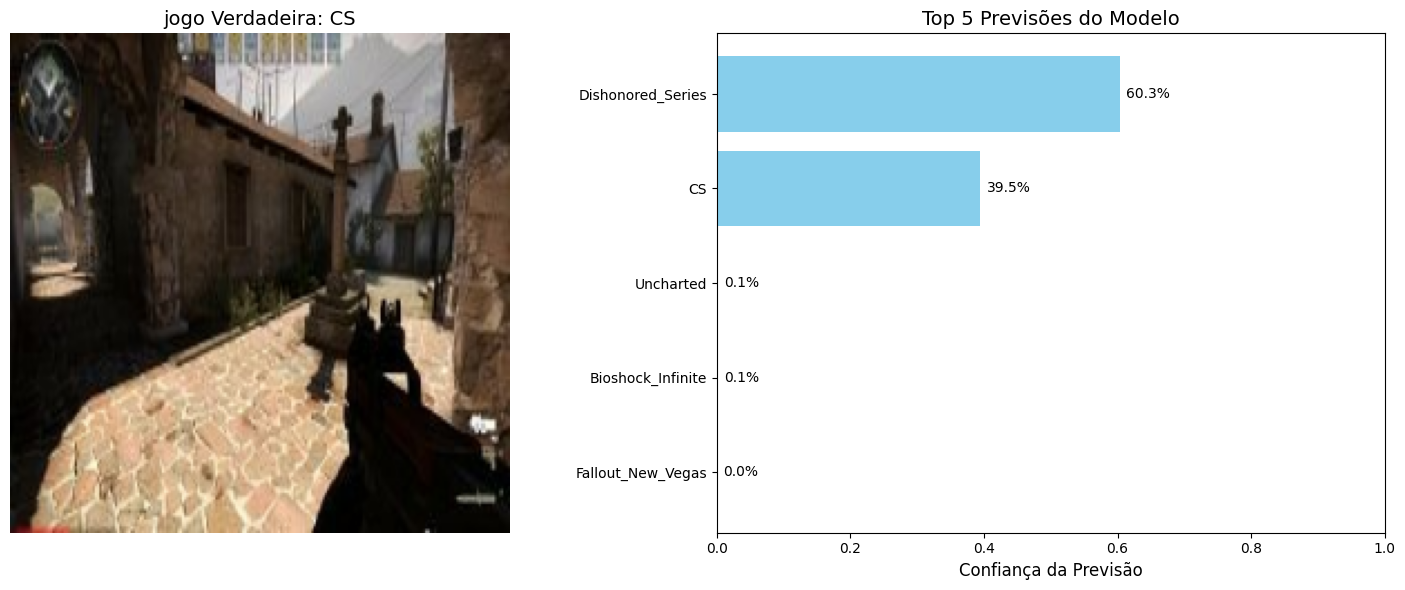

Resumo da Previsão:
A imagem era do(a) 'CS'.
O modelo previu 'Dishonored_Series' com 60.32% de confiança.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

print("--- Análise Profunda de uma Previsão Aleatória ---")

for image_batch, label_batch in val_ds.shuffle(buffer_size=1000).take(1):
    single_image = image_batch[0]
    true_label_index = label_batch[0].numpy()

image_for_prediction = tf.expand_dims(single_image, 0)
predictions = model.predict(image_for_prediction, verbose=0)

probabilities = predictions[0]
predicted_label_index = np.argmax(probabilities)

true_class_name = class_names[true_label_index]
predicted_class_name = class_names[predicted_label_index]

top_5_indices = np.argsort(probabilities)[-5:][::-1]
top_5_probs = [probabilities[i] for i in top_5_indices]
top_5_names = [class_names[i] for i in top_5_indices]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.imshow(single_image.numpy().astype("uint8"))
ax1.set_title(f"jogo Verdadeira: {true_class_name}", fontsize=14)
ax1.axis("off")

bars = ax2.barh(np.arange(len(top_5_names)), top_5_probs, color='skyblue')
ax2.set_yticks(np.arange(len(top_5_names)))
ax2.set_yticklabels(top_5_names)
ax2.invert_yaxis()
ax2.set_xlabel("Confiança da Previsão", fontsize=12)
ax2.set_title("Top 5 Previsões do Modelo", fontsize=14)
ax2.set_xlim(0, 1)

for bar in bars:
    width = bar.get_width()
    ax2.text(width + 0.01, bar.get_y() + bar.get_height()/2, f'{width:.1%}', va='center')

plt.tight_layout()
plt.show()

print(f"Resumo da Previsão:")
print(f"A imagem era do(a) '{true_class_name}'.")
print(f"O modelo previu '{predicted_class_name}' com {probabilities[predicted_label_index]:.2%} de confiança.")